# KoBERT finetuning

- https://github.com/SKTBrain/KoBERT/issues/102
- https://github.com/ChangZero/koBERT-finetuning-demo/blob/main/kobert_colab.ipynb
- https://velog.io/@ynk410/한국어를-위한-KoBERT-사용기
- https://blog.naver.com/newyearchive/223097878715
-


In [1]:
import sys

In [2]:
# !{sys.executable} -m pip install mxnet
# !{sys.executable} -m pip install gluonnlp==0.8.0
# !{sys.executable} -m pip install pandas tqdm sentencepiece
# !{sys.executable} -m pip install transformers # ==3.0.2
# !{sys.executable} -m pip install torch
# !{sys.executable} -m pip install torch --index-url https://download.pytorch.org/whl/cu117
# !{sys.executable} -m pip install ipywidgets  # for vscode

In [3]:
# !{sys.executable} -m pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [4]:
# AttributeError: module 'numpy' has no attribute 'bool'.
# https://stackoverflow.com/questions/74893742/how-to-solve-attributeerror-module-numpy-has-no-attribute-bool
import numpy as np

np.bool = np.bool_

In [5]:
import os

import gluonnlp as nlp
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

/home/j-j10d102/.conda/envs/j10d102/lib/python3.11/site-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [6]:
# CPU
# device = torch.device("cpu")

# GPU
# device = torch.device("cuda:0")

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
# from kobert import get_tokenizer
# from kobert import get_pytorch_kobert_model

from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

In [8]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [9]:
# bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")

PRETRAINED = "skt/kobert-base-v1"

tokenizer = KoBERTTokenizer.from_pretrained(PRETRAINED)
bertmodel = BertModel.from_pretrained(PRETRAINED, return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(
    tokenizer.vocab_file, padding_token="[PAD]"
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/home/j-j10d102/.conda/envs/j10d102/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [10]:
# !mkdir -p .cache
# !wget -O .cache/ratings_train.txt http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_train.txt
# !wget -O .cache/ratings_test.txt http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_test.txt

In [11]:
# https://nlp.gluon.ai/api/modules/data.html#gluonnlp.data.TSVDataset

dataset_train = nlp.data.TSVDataset(
    "./data/intent_answers_Training.tsv", field_indices=[1, 2], num_discard_samples=1
)
dataset_test = nlp.data.TSVDataset(
    "./data/intent_answers_Validation.tsv", field_indices=[1, 2], num_discard_samples=1
)

In [12]:
dataset_train[:3]

[['그리고   그 꿈을 이루기 위해서는 이 회사가 저에게는 가장 적합한 곳이라고 생각했기에 지원을 하게 됐고 여기까지 오지 않았나 생각을 합니다.',
  '7'],
 ['따라서 어떤 문제가 발생했을 때는   다시 일단 멈추고 이게 어떤 분야에서 현재 문제를 어떤 절차에서 어떤 과정에서 발생이 됐는지 또 그 이유가 뭔지를   먼저 파악해 보는 절차를 거치고요.',
  '8'],
 ['두 번째는 파악이 되면 이 문제를   애초에 그 예방할 수 있었던 측면을 다시 생각을 해보고 다음에 프로젝트를 진행할 때는   이 부분을 피해서 갈 요량으로 어떤 정의를 하는 게 하나가 있고 두 번째는 이미 지나왔고 현재 닥친 문제를 해결하기 위해서는 어떤 게 가장 효과적인 조치일까에 대해서   생각해보는 것 같습니다.',
  '8']]

In [13]:
class BERTSentenceTransform:

    def __init__(self, tokenizer, max_seq_length, vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b, self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0 : (self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        # vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return (
            np.array(input_ids, dtype="int32"),
            np.array(valid_length, dtype="int32"),
            np.array(segment_ids, dtype="int32"),
        )

In [14]:
class BERTDataset(Dataset):
    def __init__(
        self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len, pad, pair
    ):
        # transform = nlp.data.BERTSentenceTransform(
        #     bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        transform = BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair
        )

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return self.sentences[i] + (self.labels[i],)

    def __len__(self):
        return len(self.labels)

In [15]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 100
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [16]:
# tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
tok = tokenizer

# data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
# data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)
data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [17]:
train_dataloader = torch.utils.data.DataLoader(
    data_train, batch_size=batch_size, num_workers=5
)
test_dataloader = torch.utils.data.DataLoader(
    data_test, batch_size=batch_size, num_workers=5
)

In [18]:
train_dataloader

In [19]:
class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size=768, num_classes=2, dr_rate=None, params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(
            input_ids=token_ids,
            token_type_ids=segment_ids.long(),
            attention_mask=attention_mask.float().to(token_ids.device),
        )
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [20]:
# num_classes 수정

model = BERTClassifier(bertmodel, dr_rate=0.5, num_classes=16).to(device)
model

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [21]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.01,
    },
    {
        "params": [
            p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

In [22]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

/home/j-j10d102/.conda/envs/j10d102/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [24]:
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total
)

In [25]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy() / max_indices.size()[0]
    return train_acc

In [26]:
train_acc_history = []
train_loss_history = []
val_acc_history = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        train_acc_history.append(train_acc / (batch_id + 1))
        train_loss_history.append(loss.data.cpu().numpy())
        if batch_id % log_interval == 0:
            print(
                "epoch {} batch id {} loss {} train acc {}".format(
                    e + 1,
                    batch_id + 1,
                    loss.data.cpu().numpy(),
                    train_acc / (batch_id + 1),
                )
            )
    print("epoch {} train acc {}".format(e + 1, train_acc / (batch_id + 1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(
        enumerate(test_dataloader), total=len(test_dataloader)
    ):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
        val_acc_history.append(test_acc / (batch_id + 1))
    print("epoch {} test acc {}".format(e + 1, test_acc / (batch_id + 1)))

  0%|          | 0/61 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.791673183441162 train acc 0.078125
epoch 1 train acc 0.08504098360655737


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 1 test acc 0.15703125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 2.6712841987609863 train acc 0.203125
epoch 2 train acc 0.18519467213114754


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 2 test acc 0.395703125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 2.2191812992095947 train acc 0.40625
epoch 3 train acc 0.40906762295081966


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 3 test acc 0.57734375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.6554880142211914 train acc 0.703125
epoch 4 train acc 0.5771004098360656


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 4 test acc 0.596875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 1.0410103797912598 train acc 0.765625
epoch 5 train acc 0.6688012295081968


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 5 test acc 0.591015625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.7918197512626648 train acc 0.828125
epoch 6 train acc 0.7233606557377049


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 6 test acc 0.636328125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.6059681177139282 train acc 0.859375
epoch 7 train acc 0.765625


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 7 test acc 0.626953125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.5352579355239868 train acc 0.859375
epoch 8 train acc 0.7848360655737705


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 8 test acc 0.688671875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.4814446270465851 train acc 0.890625
epoch 9 train acc 0.8117315573770492


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 9 test acc 0.6515625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.45443958044052124 train acc 0.875
epoch 10 train acc 0.8386270491803278


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 10 test acc 0.65234375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.27284911274909973 train acc 0.9375
epoch 11 train acc 0.8716700819672131


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 11 test acc 0.6765625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.2745913863182068 train acc 0.9375
epoch 12 train acc 0.899077868852459


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 12 test acc 0.691796875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.16321821510791779 train acc 0.96875
epoch 13 train acc 0.9213627049180327


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 13 test acc 0.690625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.11264187842607498 train acc 0.953125
epoch 14 train acc 0.9390368852459017


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 14 test acc 0.699609375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.04221894592046738 train acc 1.0
epoch 15 train acc 0.9469774590163934


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 15 test acc 0.664453125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.20360451936721802 train acc 0.921875
epoch 16 train acc 0.9510758196721312


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 16 test acc 0.695703125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.06944775581359863 train acc 0.96875
epoch 17 train acc 0.9587602459016393


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 17 test acc 0.738671875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.04767778515815735 train acc 0.984375
epoch 18 train acc 0.970030737704918


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 18 test acc 0.75859375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.15539871156215668 train acc 0.96875
epoch 19 train acc 0.9766905737704918


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 19 test acc 0.78046875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.04046706110239029 train acc 0.984375
epoch 20 train acc 0.977202868852459


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 20 test acc 0.75703125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 0.015480410307645798 train acc 1.0
epoch 21 train acc 0.977202868852459


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 21 test acc 0.712109375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 0.028598211705684662 train acc 1.0
epoch 22 train acc 0.9825819672131147


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 22 test acc 0.7171875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 23 batch id 1 loss 0.014953133650124073 train acc 1.0
epoch 23 train acc 0.985655737704918


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 23 test acc 0.71171875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 24 batch id 1 loss 0.0290658101439476 train acc 0.984375
epoch 24 train acc 0.984375


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 24 test acc 0.721875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 25 batch id 1 loss 0.04358549788594246 train acc 0.984375
epoch 25 train acc 0.9918032786885246


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 25 test acc 0.744921875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 26 batch id 1 loss 0.004181020427495241 train acc 1.0
epoch 26 train acc 0.9933401639344263


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 26 test acc 0.72109375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 27 batch id 1 loss 0.002893490716814995 train acc 1.0
epoch 27 train acc 0.992827868852459


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 27 test acc 0.762890625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 28 batch id 1 loss 0.002963973907753825 train acc 1.0
epoch 28 train acc 0.9910348360655737


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 28 test acc 0.734765625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 29 batch id 1 loss 0.0018636488821357489 train acc 1.0
epoch 29 train acc 0.9966700819672131


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 29 test acc 0.728515625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 30 batch id 1 loss 0.0018704056274145842 train acc 1.0
epoch 30 train acc 0.9961577868852459


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 30 test acc 0.734765625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 31 batch id 1 loss 0.0017791831633076072 train acc 1.0
epoch 31 train acc 0.9964139344262295


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 31 test acc 0.754296875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 32 batch id 1 loss 0.003449753625318408 train acc 1.0
epoch 32 train acc 0.9974385245901639


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 32 test acc 0.752734375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 33 batch id 1 loss 0.001538696582429111 train acc 1.0
epoch 33 train acc 0.9969262295081968


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 33 test acc 0.746484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 34 batch id 1 loss 0.06940973550081253 train acc 0.984375
epoch 34 train acc 0.9974385245901639


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 34 test acc 0.754296875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 35 batch id 1 loss 0.0012289631413295865 train acc 1.0
epoch 35 train acc 0.9969262295081968


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 35 test acc 0.762109375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 36 batch id 1 loss 0.0009160696645267308 train acc 1.0
epoch 36 train acc 0.9966700819672131


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 36 test acc 0.74453125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 37 batch id 1 loss 0.00117368227802217 train acc 1.0
epoch 37 train acc 0.9979508196721312


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 37 test acc 0.743359375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 38 batch id 1 loss 0.000852576398756355 train acc 1.0
epoch 38 train acc 0.9982069672131147


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 38 test acc 0.75859375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 39 batch id 1 loss 0.0007004562066867948 train acc 1.0
epoch 39 train acc 0.9948770491803278


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 39 test acc 0.753125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 40 batch id 1 loss 0.0007111661252565682 train acc 1.0
epoch 40 train acc 0.9974385245901639


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 40 test acc 0.7390625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 41 batch id 1 loss 0.0009529126109555364 train acc 1.0
epoch 41 train acc 0.9989754098360656


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 41 test acc 0.752734375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 42 batch id 1 loss 0.0006284761475399137 train acc 1.0
epoch 42 train acc 0.9974385245901639


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 42 test acc 0.778125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 43 batch id 1 loss 0.0007256356766447425 train acc 1.0
epoch 43 train acc 0.9982069672131147


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 43 test acc 0.737109375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 44 batch id 1 loss 0.0005080917035229504 train acc 1.0
epoch 44 train acc 0.9989754098360656


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 44 test acc 0.768359375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 45 batch id 1 loss 0.0005589963402599096 train acc 1.0
epoch 45 train acc 0.9994877049180327


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 45 test acc 0.7625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 46 batch id 1 loss 0.0004095689801033586 train acc 1.0
epoch 46 train acc 0.9989754098360656


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 46 test acc 0.756640625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 47 batch id 1 loss 0.0004078015044797212 train acc 1.0
epoch 47 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 47 test acc 0.755078125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 48 batch id 1 loss 0.00043905232450924814 train acc 1.0
epoch 48 train acc 0.9992315573770492


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 48 test acc 0.75078125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 49 batch id 1 loss 0.00035744329215958714 train acc 1.0
epoch 49 train acc 0.9994877049180327


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 49 test acc 0.760546875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 50 batch id 1 loss 0.0003636063192971051 train acc 1.0
epoch 50 train acc 0.9994877049180327


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 50 test acc 0.750390625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 51 batch id 1 loss 0.0003412363585084677 train acc 1.0
epoch 51 train acc 0.9989754098360656


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 51 test acc 0.76484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 52 batch id 1 loss 0.0003694374463520944 train acc 1.0
epoch 52 train acc 0.9989754098360656


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 52 test acc 0.758984375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 53 batch id 1 loss 0.0002991914516314864 train acc 1.0
epoch 53 train acc 0.9994877049180327


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 53 test acc 0.75625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 54 batch id 1 loss 0.0003343007410876453 train acc 1.0
epoch 54 train acc 0.9979508196721312


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 54 test acc 0.756640625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 55 batch id 1 loss 0.0007458929321728647 train acc 1.0
epoch 55 train acc 0.9984631147540983


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 55 test acc 0.734375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 56 batch id 1 loss 0.00030584295745939016 train acc 1.0
epoch 56 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 56 test acc 0.760546875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 57 batch id 1 loss 0.0003020792792085558 train acc 1.0
epoch 57 train acc 0.9992315573770492


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 57 test acc 0.728515625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 58 batch id 1 loss 0.0003398752596694976 train acc 1.0
epoch 58 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 58 test acc 0.768359375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 59 batch id 1 loss 0.0002940294798463583 train acc 1.0
epoch 59 train acc 0.9992315573770492


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 59 test acc 0.772265625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 60 batch id 1 loss 0.0003264607803430408 train acc 1.0
epoch 60 train acc 0.9989754098360656


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 60 test acc 0.75234375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 61 batch id 1 loss 0.00026238441932946444 train acc 1.0
epoch 61 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 61 test acc 0.73515625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 62 batch id 1 loss 0.0002913538191933185 train acc 1.0
epoch 62 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 62 test acc 0.7546875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 63 batch id 1 loss 0.00024723506066948175 train acc 1.0
epoch 63 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 63 test acc 0.75859375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 64 batch id 1 loss 0.00022894398716744035 train acc 1.0
epoch 64 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 64 test acc 0.752734375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 65 batch id 1 loss 0.00022047656239010394 train acc 1.0
epoch 65 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 65 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 66 batch id 1 loss 0.0002327495312783867 train acc 1.0
epoch 66 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 66 test acc 0.75078125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 67 batch id 1 loss 0.00020306969236116856 train acc 1.0
epoch 67 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 67 test acc 0.760546875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 68 batch id 1 loss 0.00021885587193537503 train acc 1.0
epoch 68 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 68 test acc 0.760546875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 69 batch id 1 loss 0.0002651045797392726 train acc 1.0
epoch 69 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 69 test acc 0.746875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 70 batch id 1 loss 0.0002091520291287452 train acc 1.0
epoch 70 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 70 test acc 0.756640625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 71 batch id 1 loss 0.00021463197481352836 train acc 1.0
epoch 71 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 71 test acc 0.737109375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 72 batch id 1 loss 0.0002022745757130906 train acc 1.0
epoch 72 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 72 test acc 0.737109375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 73 batch id 1 loss 0.00017805761308409274 train acc 1.0
epoch 73 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 73 test acc 0.744921875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 74 batch id 1 loss 0.0001874772715382278 train acc 1.0
epoch 74 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 74 test acc 0.746875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 75 batch id 1 loss 0.0001589253224665299 train acc 1.0
epoch 75 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 75 test acc 0.744921875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 76 batch id 1 loss 0.00018800541874952614 train acc 1.0
epoch 76 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 76 test acc 0.744921875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 77 batch id 1 loss 0.00016556482296437025 train acc 1.0
epoch 77 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 77 test acc 0.746875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 78 batch id 1 loss 0.00015651201829314232 train acc 1.0
epoch 78 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 78 test acc 0.746875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 79 batch id 1 loss 0.00018012507644016296 train acc 1.0
epoch 79 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 79 test acc 0.75078125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 80 batch id 1 loss 0.00015374613576568663 train acc 1.0
epoch 80 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 80 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 81 batch id 1 loss 0.0001460761995986104 train acc 1.0
epoch 81 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 81 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 82 batch id 1 loss 0.0001740599109325558 train acc 1.0
epoch 82 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 82 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 83 batch id 1 loss 0.00015260567306540906 train acc 1.0
epoch 83 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 83 test acc 0.75078125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 84 batch id 1 loss 0.00018501345766708255 train acc 1.0
epoch 84 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 84 test acc 0.75078125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 85 batch id 1 loss 0.00015142554184421897 train acc 1.0
epoch 85 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 85 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 86 batch id 1 loss 0.00015252121374942362 train acc 1.0
epoch 86 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 86 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 87 batch id 1 loss 0.00017811378347687423 train acc 1.0
epoch 87 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 87 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 88 batch id 1 loss 0.0001586323487572372 train acc 1.0
epoch 88 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 88 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 89 batch id 1 loss 0.00014081754488870502 train acc 1.0
epoch 89 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 89 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 90 batch id 1 loss 0.000142692617373541 train acc 1.0
epoch 90 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 90 test acc 0.746875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 91 batch id 1 loss 0.00015669935964979231 train acc 1.0
epoch 91 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 91 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 92 batch id 1 loss 0.00014871601888444275 train acc 1.0
epoch 92 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 92 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 93 batch id 1 loss 0.00013240006228443235 train acc 1.0
epoch 93 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 93 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 94 batch id 1 loss 0.00014543667202815413 train acc 1.0
epoch 94 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 94 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 95 batch id 1 loss 0.00015651834837626666 train acc 1.0
epoch 95 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 95 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 96 batch id 1 loss 0.0001592760963831097 train acc 1.0
epoch 96 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 96 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 97 batch id 1 loss 0.0001482068473706022 train acc 1.0
epoch 97 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 97 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 98 batch id 1 loss 0.0001383123017149046 train acc 1.0
epoch 98 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 98 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 99 batch id 1 loss 0.00014913863560650498 train acc 1.0
epoch 99 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 99 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 100 batch id 1 loss 0.00015057099517434835 train acc 1.0
epoch 100 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 100 test acc 0.748828125


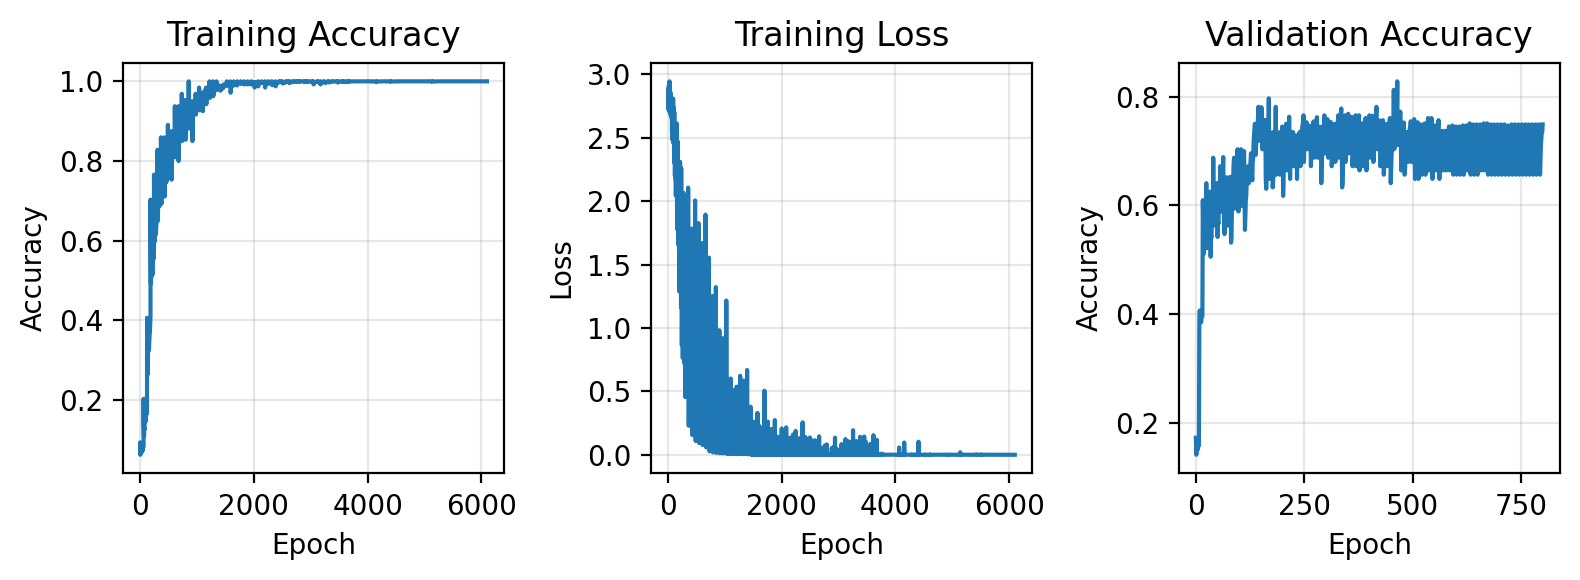

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=200)

axes[0].set_title("Training Accuracy")
axes[0].plot(range(len(train_acc_history)),
             train_acc_history, label="Train Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True, alpha=0.3)

axes[1].set_title("Training Loss")
axes[1].plot(range(len(train_loss_history)),
             train_loss_history, label="Train Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True, alpha=0.3)

axes[2].set_title("Validation Accuracy")
axes[2].plot(range(len(val_acc_history)),
             val_acc_history, label="Validation Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close(fig)

In [28]:
# 학습 모델 저장
PATH = "./models/KoBERT"
os.makedirs(PATH, exist_ok=True)

torch.save(model, PATH + "KoBERT.pt")  # 전체 모델 저장
# 모델 객체의 state_dict 저장
torch.save(model.state_dict(), PATH + "model_state_dict.pt")
torch.save(
    {"model": model.state_dict(), "optimizer": optimizer.state_dict()
     }, PATH + "all.tar"
)  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능